In [1]:
import numpy as np
import pandas as pd
import networkx as nx

import seaborn as sns
import matplotlib.pyplot as plt

import scipy.io
import os

import mne
from scipy.signal import coherence, hilbert

In [2]:
colors = [
    'tab:blue',      # azul
    'tab:orange',    # naranja
    'tab:green',     # verde
    'tab:red',       # rojo
    'tab:purple',    # morado
    'tab:brown',     # café
    'tab:pink',      # rosa
    'tab:gray',      # gris
    'tab:olive',     # verde oliva
    'tab:cyan',      # cian
    'gold',          # dorado
    'deepskyblue',   # azul brillante
    'limegreen',     # verde limón
    'magenta',       # magenta
    'black'          # negro
]

In [3]:
def plot_grafos(eeg_graph, df_filtered_):
    from mpl_toolkits.mplot3d.art3d import Line3DCollection
    
    %matplotlib widget
    
    fig = plt.figure(figsize=(12, 8))
    # axes = [fig.add_subplot(1, 2, i + 1, projection='3d') for i in range(2)]
    axes = [
        fig.add_subplot(2, 2, 1),                     # 2D
        fig.add_subplot(2, 2, 2, projection='3d'),    # 3D
        fig.add_subplot(2, 2, 3, projection='3d'),    # 3D
        fig.add_subplot(2, 2, 4, projection='3d')     # 3D
    ]
    
    ######################## GRAFO 2D ######################################
    nx.draw_circular(eeg_graph, with_labels=True, font_size=5, ax=axes[0])
    axes[0].set_title("grafo 2D")
    
    ######################## GRAFO 3D ######################################
    x, y, z = eeg_coords['x'].values, eeg_coords['y'].values, eeg_coords['z'].values
    # DIBUJAR LOS NODOS
    for idx, (x_, y_, z_) in enumerate(zip(x, y, z)):
        axes[1].text(x_, y_, z_, eeg_coords.index[idx], fontsize=5, ha='center')
        if eeg_coords.index[idx] == hub[0]:
            axes[1].text(x_, y_, z_-0.1, 'HUB', color='red', fontweight='bold', fontsize=10, ha='center')
    
    # Dibujar aristas (basado en comunidades)
    for idx, edge in enumerate(eeg_graph.edges):
        nodo1, nodo2 = edge[0], edge[1]
        x_ = [eeg_coords.loc[nodo1, 'x'], eeg_coords.loc[nodo2, 'x']]
        y_ = [eeg_coords.loc[nodo1, 'y'], eeg_coords.loc[nodo2, 'y']]
        z_ = [eeg_coords.loc[nodo1, 'z'], eeg_coords.loc[nodo2, 'z']]
        axes[1].plot(x_, y_, z_, alpha=0.4, linewidth=3)
    
    axes[1].set_title("grafo 3D")
    
    ####################### COMUNIDADES #####################################
    nodo_size = [50 if idx != hub[0] else 200 for idx in eeg_coords.index]
    # DIBUJAR LOS NODOS
    axes[2].scatter(x, y, z, s=nodo_size, alpha=0.5)#, c=degree_dict.values(), cmap='hot')
    for idx, (x_, y_, z_) in enumerate(zip(x, y, z)):
        axes[2].text(x_, y_, z_, eeg_coords.index[idx], fontsize=5, ha='center')
        if eeg_coords.index[idx] == hub[0]:
            axes[2].text(x_, y_, z_-0.1, 'HUB', color='red', fontweight='bold', fontsize=10, ha='center')
    
    # Dibujar aristas (basado en comunidades)
    for n_communitie, communitie in enumerate(communities):
        for idx in range(len(communitie)-1):
            nodo1, nodo2 = list(communitie)[idx], list(communitie)[idx+1]
            x_ = [eeg_coords.loc[nodo1, 'x'], eeg_coords.loc[nodo2, 'x']]
            y_ = [eeg_coords.loc[nodo1, 'y'], eeg_coords.loc[nodo2, 'y']]
            z_ = [eeg_coords.loc[nodo1, 'z'], eeg_coords.loc[nodo2, 'z']]
            axes[2].plot(x_, y_, z_, color=colors[n_communitie], alpha=0.4, linewidth=3)
    
    axes[2].set_xlabel('X')
    axes[2].set_ylabel('Y')
    axes[2].set_zlabel('Z')
    axes[2].set_title("Comunidades")
    
    
    ####################### GRADO Y CONEXIONES ##############################
    # DIBUJAR LOS NODOS
    # nodo_size = [50 if idx != hub[0] else 200 for idx in eeg_coords.index]
    # sc = ax.scatter(x, y, z, s=nodo_size, alpha=0.5)#, c=degree_dict.values(), cmap='hot')
    axes[3].scatter(x, y, z, s=np.array(list(degree_dict.values()))*20, alpha=0.5)#, c=degree_dict.values(), cmap='hot')
    for idx, (x_, y_, z_) in enumerate(zip(x, y, z)):
        axes[3].text(x_, y_, z_, eeg_coords.index[idx], fontsize=5, ha='center')
        if eeg_coords.index[idx] == hub[0]:
            axes[3].text(x_, y_, z_-0.1, 'HUB', color='red', fontweight='bold', fontsize=10, ha='center')
    
    # Dibujar aristas (basado en comunidades)
    colors_, segments = [], []
    for idx, edge in enumerate(eeg_graph.edges):
        nodo1, nodo2 = edge[0], edge[1]
        x_ = [eeg_coords.loc[nodo1, 'x'], eeg_coords.loc[nodo2, 'x']]
        y_ = [eeg_coords.loc[nodo1, 'y'], eeg_coords.loc[nodo2, 'y']]
        z_ = [eeg_coords.loc[nodo1, 'z'], eeg_coords.loc[nodo2, 'z']]
        axes[3].plot(x_, y_, z_, alpha=0.4, linewidth=3)
    
        segment = np.column_stack([x_, y_, z_])
        segments.append(segment)
        colors_.append(df_filtered_.loc[nodo1, nodo2])
    
    colors_ = np.array(colors_)
    # Crear colección de líneas 3D
    lc = Line3DCollection(
        segments,
        linewidths=3, #weights,
        cmap='hot_r',
        norm=plt.Normalize(vmin=colors_.min(), vmax=colors_.max()),
        alpha=0.5
    )
    lc.set_array(colors_)
    
    # Añadir al eje
    axes[3].add_collection3d(lc)
    
    axes[3].set_xlabel('X')
    axes[3].set_ylabel('Y')
    axes[3].set_zlabel('Z')
    axes[3].set_title("Grados y conexiones")

In [4]:
def metricas_grafo(G):
    # Métricas:
    # (a) Clustering promedio (coeficiente de agrupamiento)
    clust_coeff = nx.average_clustering(G)
    # (b) Longitud de camino promedio (camino más corto)
    try:
        path_length = nx.average_shortest_path_length(G)
    except nx.NetworkXError:
        path_length = np.nan  # red no conexa
    # (c) Small-worldness (ejemplo simplificado)
    # Comparar con grafo aleatorio de igual N, K
    G_rand = nx.gnm_random_graph(n=G.number_of_nodes(), m=G.number_of_edges())
    clust_rand = nx.average_clustering(G_rand)
    path_rand = nx.average_shortest_path_length(G_rand)
    small_world_sigma = (clust_coeff / clust_rand) / (path_length / path_rand)
    
    # (d) Modularidad — usando método de comunidades
    from networkx.algorithms import community
    communities = community.greedy_modularity_communities(G)
    modularity = community.modularity(G, communities)
    
    # (e) Hubs — grado, centralidad de intermediación
    degree_dict = dict(G.degree())
    betweenness = nx.betweenness_centrality(G)
    betweenness = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)
    
    # (f) Eficiencia global y local
    global_eff = nx.global_efficiency(G)
    local_eff = nx.local_efficiency(G)

    return clust_coeff, path_length, small_world_sigma, communities, modularity, betweenness, global_eff, local_eff, degree_dict

In [5]:
def crear_matriz(data, ch_names, sfreq_target, fmin, fmax, metodo="coherencia"):
    # ====== 1. MATRIZ DE CORRELACIÓN DE PEARSON ======
    if metodo == "correlacion":
        corr_matrix = np.corrcoef(data)
        corr_df = pd.DataFrame(corr_matrix, index=ch_names, columns=ch_names)
        return corr_df
    
    # ====== 2. MATRIZ DE COHERENCIA ESPECTRAL ======
    elif metodo == "coherencia":
        n_channels = len(ch_names)
        coh_matrix = np.zeros((n_channels, n_channels))
        for i in range(n_channels):
            for j in range(n_channels):
                f, Cxy = coherence(data[i], data[j], fs=sfreq_target, nperseg=sfreq_target*2)
                mask = (f >= fmin) & (f <= fmax)
                coh_matrix[i, j] = np.mean(Cxy[mask])
        
        coh_df = pd.DataFrame(coh_matrix, index=ch_names, columns=ch_names)
        return coh_df
    
    # ====== 3. MATRIZ DE PHASE LOCKING VALUE (PLV) ======
    elif metodo == 'PLV':
        analytic_signal = hilbert(data)
        phase_data = np.angle(analytic_signal)
        
        plv_matrix = np.zeros((n_channels, n_channels))
        for i in range(n_channels):
            for j in range(n_channels):
                phase_diff = phase_data[i] - phase_data[j]
                plv_matrix[i, j] = np.abs(np.sum(np.exp(1j * phase_diff)) / phase_diff.size)
        
        plv_df = pd.DataFrame(plv_matrix, index=ch_names, columns=ch_names)
        return plv_df
    else:
        return pd.DataFrame()

In [6]:
def print_estadisticos(th25, th50, th75, mean, sigma):
    estadisticas = pd.DataFrame(columns=['perc_25', 'perc_50', 'perc_75', 'mean', 'sigma', 'mean+sigma'], index=['min', 'max', 'mean', 'sigma'])

    estadisticas.loc['min', 'perc_25'] = np.min(th25)
    estadisticas.loc['max', 'perc_25'] = np.max(th25)
    estadisticas.loc['mean', 'perc_25'] = np.mean(th25)
    estadisticas.loc['sigma', 'perc_25'] = np.std(th25)
    estadisticas.loc['min', 'perc_50'] = np.min(th50)
    estadisticas.loc['max', 'perc_50'] = np.max(th50)
    estadisticas.loc['mean', 'perc_50'] = np.mean(th50)
    estadisticas.loc['sigma', 'perc_50'] = np.std(th50)
    estadisticas.loc['min', 'perc_75'] = np.min(th75)
    estadisticas.loc['max', 'perc_75'] = np.max(th75)
    estadisticas.loc['mean', 'perc_75'] = np.mean(th75)
    estadisticas.loc['sigma', 'perc_75'] = np.std(th75)
    estadisticas.loc['min', 'mean'] = np.min(mean)
    estadisticas.loc['max', 'mean'] = np.max(mean)
    estadisticas.loc['mean', 'mean'] = np.mean(mean)
    estadisticas.loc['sigma', 'mean'] = np.std(mean)
    estadisticas.loc['min', 'sigma'] = np.min(sigma)
    estadisticas.loc['max', 'sigma'] = np.max(sigma)
    estadisticas.loc['mean', 'sigma'] = np.mean(sigma)
    estadisticas.loc['sigma', 'sigma'] = np.std(sigma)
    estadisticas.loc['min', 'mean+sigma'] = np.min(np.array(mean)+np.array(sigma))
    estadisticas.loc['max', 'mean+sigma'] = np.max(np.array(mean)+np.array(sigma))
    estadisticas.loc['mean', 'mean+sigma'] = np.mean(np.array(mean)+np.array(sigma))
    estadisticas.loc['sigma', 'mean+sigma'] = np.std(np.array(mean)+np.array(sigma))
    
    print('\033[1m Estadísticas de los umbrales')
    print(estadisticas)

def plot_estadisticos_ensayos(eeg_dfs):
    fig, axes = plt.subplots(2, 2, figsize=(12, 7))
    
    th25, th50, th75, mean, sigma = [], [], [], [], []
    
    plt.subplots_adjust(hspace=0.5)
    for eeg_df in eeg_dfs:
        data = eeg_df.stack().values
        sns.histplot(data, ax=axes[0][0], kde=True)
        sns.ecdfplot(data, ax=axes[0][1])
    
        th25.append(np.percentile(data, 25))
        th50.append(np.percentile(data, 50))
        th75.append(np.percentile(data, 75))
        mean.append(np.mean(data))
        sigma.append(np.std(data))
    
    axes[1][0].plot(th25, label='Percentil 25%')
    axes[1][0].plot(th50, label='Percentil 50%')
    axes[1][0].plot(th75, label='Percentil 75%')
    axes[1][0].plot(np.array(mean)+np.array(sigma), label='Mean+Sigma')
    axes[1][0].plot(mean, label='Media')
    axes[1][0].plot(sigma, label='Varianza')
    axes[1][0].set_xlabel('Número de ensayo')
    axes[1][0].legend()
        
    axes[0][0].set_title('Histograma')
    axes[0][1].set_title('Datos acumulados')
    axes[1][0].set_title('Umbrales')

    print_estadisticos(th25, th50, th75, mean, sigma)

    return th25, th50, th75, mean, sigma

In [7]:
def filtrado_ensayos(df_list, threshold, porcentaje):
    # Convierte todos a numpy y apílalos
    stacked = np.stack([df.values for df in df_list])
    
    above = stacked > threshold 
    
    N = len(df_list)
    
    # Cuenta cuántos superan el umbral
    count_above = above.sum(axis=0)
    
    # Condición de porcentaje
    min_required = int(np.ceil(porcentaje * N))
    
    # Matriz final booleana
    result_bool = count_above >= min_required
    
    # Si quieres un dataframe:
    result_df = pd.DataFrame(result_bool, index=df_list[0].index, columns=df_list[0].columns).astype(int)

    return result_df

In [8]:
def carga_y_procesamiento(edf_file_path, fmin=8, fmax=13):
    # ====== CARGA Y PREPROCESAMIENTO ======
    raw = mne.io.read_raw_edf(edf_file_path, preload=True)
    sfreq_target = raw.info['sfreq']# Frecuencia de muestreo a la que normalizamos (Hz)
    # fmin, fmax = 8, 13            # Banda alfa para la coherencia (puedes ajustar)
    
    raw.resample(sfreq_target)
    raw.filter(1., 45., fir_design='firwin')
    eeg_data = raw.get_data()
    ch_names = raw.info['ch_names']
    n_channels = len(ch_names)

    return eeg_data, ch_names, sfreq_target

In [9]:
def leer_archivos_de_folder(edf_path):
    # Leer todos los archivos .edf del folder
    edf_files_path = []
    for root, dirs, files in os.walk(edf_path):
        for file in files:
            if file.endswith(".edf"):
                edf_files_path.append(os.path.join(root, file))

    return edf_files_path

In [10]:
def lee_ensayo_dfs(ensayo_dict):
    ensayo_dfs = []
    for hoja in ensayo_dict.keys():
        ensayo_dfs.append(ensayo_dict[hoja])

    return ensayo_dfs

# Path con ensayos y sujetos

In [11]:
edf_path_ = r"..\S03_datasets\eeg-motor-movementimagery"

edf_files_path_ = leer_archivos_de_folder(edf_path_)

In [12]:
# Coordenadas de electrodos
eeg_coords_csv = r"..\S03_datasets\eeg-motor-movementimagery\MI_coordinates.csv"
eeg_coords = pd.read_csv(eeg_coords_csv)

eeg_coords.set_index("canal", drop=True, inplace=True)

# Conjunción de ensayos

In [8]:
# Creamos estructura para guardar los datasets
edf_sujetos = []

no_runs = 14
for run in range(no_runs):
    edf_sujetos.append([])

In [10]:
fmin, fmax = 13, 30 # Se escoge la banda beta

for idx, edf_file_path_ in enumerate(edf_files_path_):
    ensayo = idx % no_runs
    sujeto = idx // no_runs
    print(f"Procesando sujeto {idx // no_runs + 1}, ensayo {ensayo + 1}")
    # # edf_file_path_ = edf_files_path_[0]
    data_, ch_names_, sfreq_target_ = carga_y_procesamiento(edf_file_path_, fmin, fmax)
    
    # Creacion de matriz
    eeg_df = crear_matriz(data_, ch_names_, sfreq_target_, fmin, fmax)
    # Se cambia la diagonal a 0
    np.fill_diagonal(eeg_df.values, 0)

    edf_sujetos[ensayo].append(eeg_df)
    

Procesando sujeto 1, ensayo 1
Extracting EDF parameters from C:\Users\OMEN CI7\Documents\repository\Neurociencias-2026-1\S03_datasets\eeg-motor-movementimagery\S001\S001R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Sampling frequency of the instance is already 160.0, returning unmodified.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 529 samples (3.306 s)

Procesando sujeto 1, ensayo 2
Extracting EDF p

C:\Users\OMEN CI7\AppData\Local\Temp\ipykernel_28084\2786304425.py:3: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(edf_file_path, preload=True)


Procesando sujeto 100, ensayo 4
Extracting EDF parameters from C:\Users\OMEN CI7\Documents\repository\Neurociencias-2026-1\S03_datasets\eeg-motor-movementimagery\S100\S100R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15743  =      0.000 ...   122.992 secs...
Sampling frequency of the instance is already 128.0, returning unmodified.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 423 samples (3.305 s)



C:\Users\OMEN CI7\AppData\Local\Temp\ipykernel_28084\2786304425.py:3: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(edf_file_path, preload=True)


Procesando sujeto 100, ensayo 5
Extracting EDF parameters from C:\Users\OMEN CI7\Documents\repository\Neurociencias-2026-1\S03_datasets\eeg-motor-movementimagery\S100\S100R05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15743  =      0.000 ...   122.992 secs...
Sampling frequency of the instance is already 128.0, returning unmodified.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 423 samples (3.305 s)



C:\Users\OMEN CI7\AppData\Local\Temp\ipykernel_28084\2786304425.py:3: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(edf_file_path, preload=True)


Procesando sujeto 100, ensayo 6
Extracting EDF parameters from C:\Users\OMEN CI7\Documents\repository\Neurociencias-2026-1\S03_datasets\eeg-motor-movementimagery\S100\S100R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15743  =      0.000 ...   122.992 secs...
Sampling frequency of the instance is already 128.0, returning unmodified.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 423 samples (3.305 s)



C:\Users\OMEN CI7\AppData\Local\Temp\ipykernel_28084\2786304425.py:3: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(edf_file_path, preload=True)


Procesando sujeto 100, ensayo 7
Extracting EDF parameters from C:\Users\OMEN CI7\Documents\repository\Neurociencias-2026-1\S03_datasets\eeg-motor-movementimagery\S100\S100R07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15743  =      0.000 ...   122.992 secs...
Sampling frequency of the instance is already 128.0, returning unmodified.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 423 samples (3.305 s)



C:\Users\OMEN CI7\AppData\Local\Temp\ipykernel_28084\2786304425.py:3: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(edf_file_path, preload=True)


Procesando sujeto 100, ensayo 8
Extracting EDF parameters from C:\Users\OMEN CI7\Documents\repository\Neurociencias-2026-1\S03_datasets\eeg-motor-movementimagery\S100\S100R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15743  =      0.000 ...   122.992 secs...
Sampling frequency of the instance is already 128.0, returning unmodified.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 423 samples (3.305 s)



C:\Users\OMEN CI7\AppData\Local\Temp\ipykernel_28084\2786304425.py:3: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(edf_file_path, preload=True)


Procesando sujeto 100, ensayo 9
Extracting EDF parameters from C:\Users\OMEN CI7\Documents\repository\Neurociencias-2026-1\S03_datasets\eeg-motor-movementimagery\S100\S100R09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15743  =      0.000 ...   122.992 secs...
Sampling frequency of the instance is already 128.0, returning unmodified.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 423 samples (3.305 s)



C:\Users\OMEN CI7\AppData\Local\Temp\ipykernel_28084\2786304425.py:3: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(edf_file_path, preload=True)


Procesando sujeto 100, ensayo 10
Extracting EDF parameters from C:\Users\OMEN CI7\Documents\repository\Neurociencias-2026-1\S03_datasets\eeg-motor-movementimagery\S100\S100R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15743  =      0.000 ...   122.992 secs...
Sampling frequency of the instance is already 128.0, returning unmodified.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 423 samples (3.305 s)



C:\Users\OMEN CI7\AppData\Local\Temp\ipykernel_28084\2786304425.py:3: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(edf_file_path, preload=True)


Procesando sujeto 100, ensayo 11
Extracting EDF parameters from C:\Users\OMEN CI7\Documents\repository\Neurociencias-2026-1\S03_datasets\eeg-motor-movementimagery\S100\S100R11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15743  =      0.000 ...   122.992 secs...
Sampling frequency of the instance is already 128.0, returning unmodified.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 423 samples (3.305 s)



C:\Users\OMEN CI7\AppData\Local\Temp\ipykernel_28084\2786304425.py:3: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(edf_file_path, preload=True)


Procesando sujeto 100, ensayo 12
Extracting EDF parameters from C:\Users\OMEN CI7\Documents\repository\Neurociencias-2026-1\S03_datasets\eeg-motor-movementimagery\S100\S100R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15743  =      0.000 ...   122.992 secs...
Sampling frequency of the instance is already 128.0, returning unmodified.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 423 samples (3.305 s)



C:\Users\OMEN CI7\AppData\Local\Temp\ipykernel_28084\2786304425.py:3: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(edf_file_path, preload=True)


Procesando sujeto 100, ensayo 13
Extracting EDF parameters from C:\Users\OMEN CI7\Documents\repository\Neurociencias-2026-1\S03_datasets\eeg-motor-movementimagery\S100\S100R13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15743  =      0.000 ...   122.992 secs...
Sampling frequency of the instance is already 128.0, returning unmodified.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 423 samples (3.305 s)



C:\Users\OMEN CI7\AppData\Local\Temp\ipykernel_28084\2786304425.py:3: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(edf_file_path, preload=True)


Procesando sujeto 100, ensayo 14
Extracting EDF parameters from C:\Users\OMEN CI7\Documents\repository\Neurociencias-2026-1\S03_datasets\eeg-motor-movementimagery\S100\S100R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15743  =      0.000 ...   122.992 secs...
Sampling frequency of the instance is already 128.0, returning unmodified.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 423 samples (3.305 s)



C:\Users\OMEN CI7\AppData\Local\Temp\ipykernel_28084\2786304425.py:3: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(edf_file_path, preload=True)


Procesando sujeto 101, ensayo 1
Extracting EDF parameters from C:\Users\OMEN CI7\Documents\repository\Neurociencias-2026-1\S03_datasets\eeg-motor-movementimagery\S101\S101R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Sampling frequency of the instance is already 160.0, returning unmodified.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 529 samples (3.306 s)

Procesando sujeto 101, ensayo 2
Extracting E

In [11]:
print('Total de sujetos ', len(edf_sujetos))
for idx, edf_sujeto in enumerate(edf_sujetos):
    print(f'Sujeto {idx+1} tiene {len(edf_sujeto)} ensayos')

Total de sujetos  14
Sujeto 1 tiene 109 ensayos
Sujeto 2 tiene 109 ensayos
Sujeto 3 tiene 109 ensayos
Sujeto 4 tiene 109 ensayos
Sujeto 5 tiene 109 ensayos
Sujeto 6 tiene 109 ensayos
Sujeto 7 tiene 109 ensayos
Sujeto 8 tiene 109 ensayos
Sujeto 9 tiene 109 ensayos
Sujeto 10 tiene 109 ensayos
Sujeto 11 tiene 109 ensayos
Sujeto 12 tiene 109 ensayos
Sujeto 13 tiene 109 ensayos
Sujeto 14 tiene 109 ensayos


# Guardar los dataframes en excel files

In [12]:
for idx_sujeto, sujeto in enumerate(edf_sujetos):
    nombre_archivo = r'..\S03_datasets\eeg-motor-movementimagery_Ensayo_'+str(idx_sujeto+1).zfill(2)+'.xlsx'
    with pd.ExcelWriter(nombre_archivo) as writer:
        for idx, ensayo in enumerate(sujeto):
            ensayo.to_excel(writer, sheet_name=f'Sujeto{idx+1}', index=True)

# Abrir los dataframes de un excel

In [13]:
ensayo3_dict = pd.read_excel(r'..\S03_datasets\eeg-motor-movementimagery_Ensayo_03.xlsx', sheet_name=None, index_col=0)
ensayo4_dict = pd.read_excel(r'..\S03_datasets\eeg-motor-movementimagery_Ensayo_04.xlsx', sheet_name=None, index_col=0)

In [14]:
ensayo3_dfs = lee_ensayo_dfs(ensayo3_dict)
ensayo4_dfs = lee_ensayo_dfs(ensayo4_dict)

In [15]:
ensayo3_dfs[0]

Fc5.      Fc3.      Fc1.      Fcz.      Fc2.      Fc4.      Fc6.  \
Fc5.  0.000000  0.867923  0.700735  0.525544  0.450264  0.362137  0.259564   
Fc3.  0.867923  0.000000  0.918912  0.731142  0.628317  0.503466  0.353005   
Fc1.  0.700735  0.918912  0.000000  0.897501  0.797551  0.646089  0.452418   
Fcz.  0.525544  0.731142  0.897501  0.000000  0.922947  0.778286  0.551145   
Fc2.  0.450264  0.628317  0.797551  0.922947  0.000000  0.923431  0.696435   
...        ...       ...       ...       ...       ...       ...       ...   
Po8.  0.101002  0.112443  0.120838  0.120982  0.140344  0.150086  0.133999   
O1..  0.273973  0.264749  0.245041  0.218634  0.216206  0.196400  0.155667   
Oz..  0.215420  0.217149  0.210811  0.192018  0.198775  0.189580  0.156252   
O2..  0.131835  0.139296  0.143004  0.134798  0.147748  0.147815  0.125630   
Iz..  0.196033  0.179823  0.168671  0.151215  0.156963  0.151460  0.130997   

          C5..      C3..      C1..  ...      P8..      Po7.      Po3.  \
Fc5.  0.861015  0.766298  0.648149  ...  0.138347  0.322246  0.351895   
Fc3.  0.777415  0.856793  0.823418  ...  0.159894  0.299068  0.345380   
Fc1.  0.629695  0.783132  0.877966  ...  0.178323  0.266574  0.315884   
Fcz.  0.480637  0.634787  0.808481  ...  0.185012  0.231927  0.277029   
Fc2.  0.423512  0.562817  0.741922  ...  0.217216  0.226418  0.268882   
...        ...       ...       ...  ...       ...       ...       ...   
Po8.  0.154087  0.182202  0.210618  ...  0.824844  0.314701  0.341426   
O1..  0.409722  0.433927  0.409430  ...  0.403255  0.929877  0.916406   
Oz..  0.318516  0.353081  0.361117  ...  0.579893  0.692796  0.718733   
O2..  0.196138  0.226527  0.247463  ...  0.671540  0.418285  0.443790   
Iz..  0.265635  0.272846  0.267157  ...  0.468302  0.574173  0.549535   

          Poz.      Po4.      Po8.      O1..      Oz..      O2..      Iz..  
Fc5.  0.278823  0.166879  0.101002  0.273973  0.215420  0.131835  0.196033  
Fc3.  0.307711  0.197832  0.112443  0.264749  0.217149  0.139296  0.179823  
Fc1.  0.314338  0.218866  0.120838  0.245041  0.210811  0.143004  0.168671  
Fcz.  0.296539  0.222188  0.120982  0.218634  0.192018  0.134798  0.151215  
Fc2.  0.301561  0.248479  0.140344  0.216206  0.198775  0.147748  0.156963  
...        ...       ...       ...       ...       ...       ...       ...  
Po8.  0.579267  0.884506  0.000000  0.430457  0.676912  0.846844  0.549497  
O1..  0.814436  0.544241  0.430457  0.000000  0.848010  0.560410  0.712612  
Oz..  0.866896  0.761047  0.676912  0.848010  0.000000  0.822693  0.836101  
O2..  0.671358  0.819316  0.846844  0.560410  0.822693  0.000000  0.710817  
Iz..  0.609531  0.550337  0.549497  0.712612  0.836101  0.710817  0.000000  

[64 rows x 64 columns]

# Task 1 (open and close left or right fist)

 Estadísticas de los umbrales
        perc_25   perc_50   perc_75      mean     sigma mean+sigma
min    0.018413   0.06175  0.196867  0.149821   0.16782   0.340611
max    0.514472  0.674805  0.819681  0.626848  0.266529   0.857561
mean   0.166961  0.295352  0.489628  0.345504  0.224412   0.569916
sigma  0.108282  0.127829  0.122228  0.102222  0.021782   0.103658


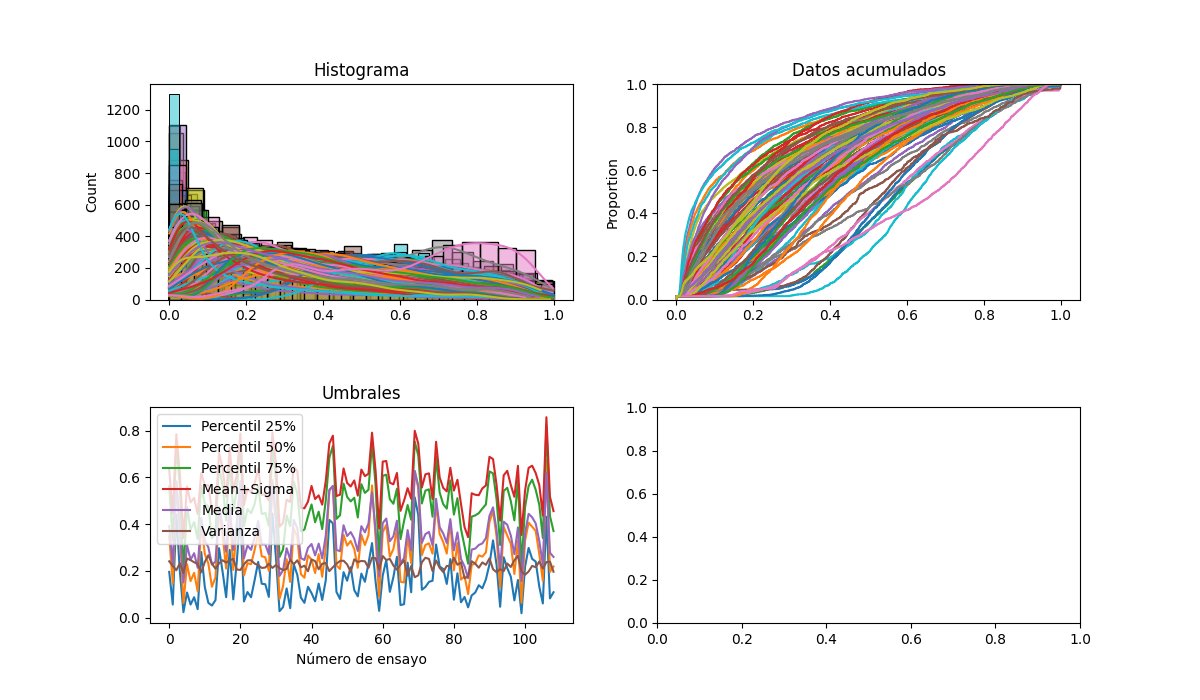

In [27]:
eeg_dfs_ = ensayo3_dfs

# Análisis exploratorio de datos
th25_, th50_, th75_, mean_, sigma_ = plot_estadisticos_ensayos(eeg_dfs_)

# Filtrado de ensayos

In [28]:
df_filtered_04 = filtrado_ensayos(eeg_dfs_, threshold=np.mean(np.array(mean_)+np.array(sigma_)), porcentaje=0.4)
df_filtered_06 = filtrado_ensayos(eeg_dfs_, threshold=np.mean(np.array(mean_)+np.array(sigma_)), porcentaje=0.6)
df_filtered_08 = filtrado_ensayos(eeg_dfs_, threshold=np.mean(np.array(mean_)+np.array(sigma_)), porcentaje=0.8)
df_filtered_10 = filtrado_ensayos(eeg_dfs_, threshold=np.mean(np.array(mean_)+np.array(sigma_)), porcentaje=1.0)

Text(0.5, 1.0, 'Binarizado con umbral para el 100%')

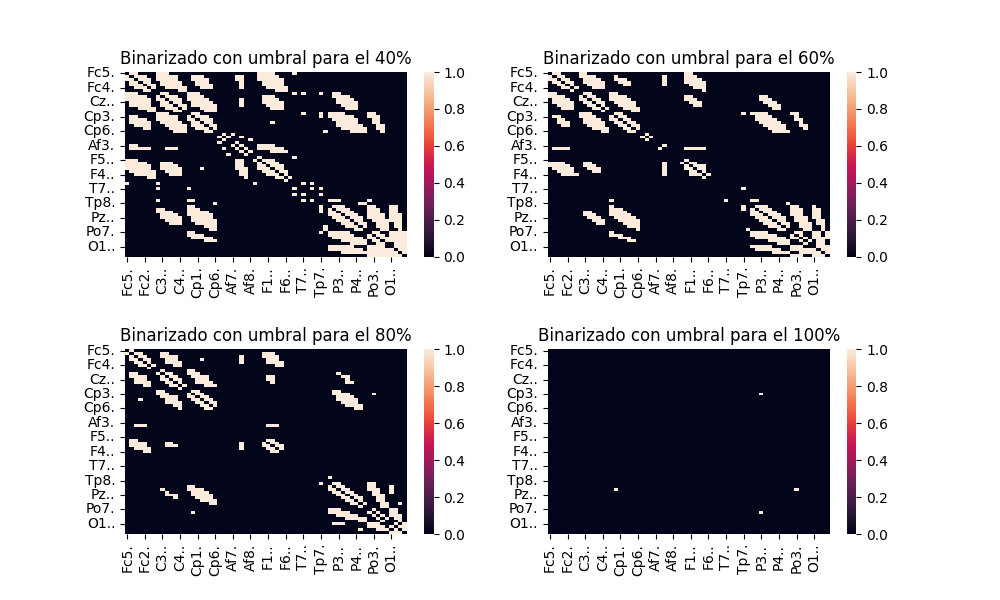

In [29]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

plt.subplots_adjust(hspace=0.5)
sns.heatmap(df_filtered_04, ax=axes[0][0])
sns.heatmap(df_filtered_06, ax=axes[0][1])
sns.heatmap(df_filtered_08, ax=axes[1][0])
sns.heatmap(df_filtered_10, ax=axes[1][1])

axes[0][0].set_title('Binarizado con umbral para el 40%')
axes[0][1].set_title('Binarizado con umbral para el 60%')
axes[1][0].set_title('Binarizado con umbral para el 80%')
axes[1][1].set_title('Binarizado con umbral para el 100%')

# Análisis de grafos

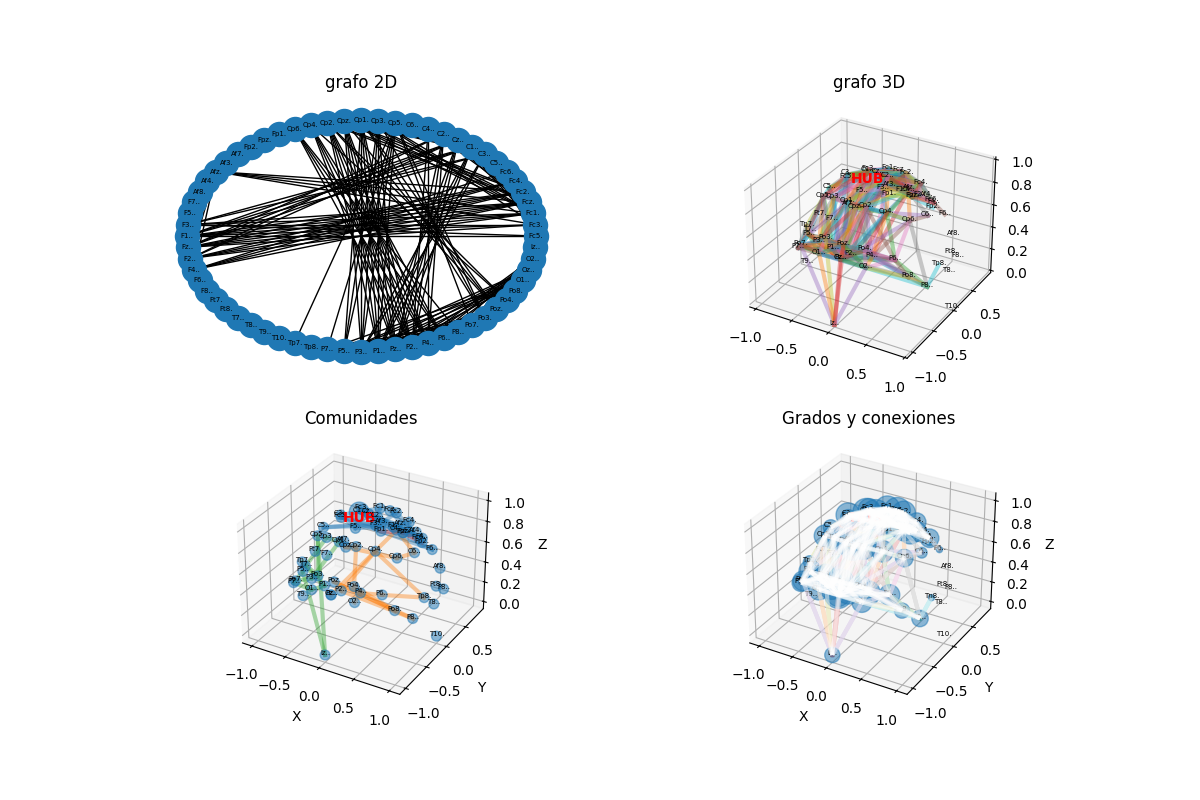

In [30]:
# Generar grafo desde matriz
df_filtered = df_filtered_06
eeg_graph_ = nx.from_pandas_adjacency(df_filtered, create_using=nx.Graph())

clust_coeff, path_length, small_world_sigma, communities, modularity, betweenness, global_eff, local_eff, degree_dict = metricas_grafo(eeg_graph_)

hub = betweenness[0]

plot_grafos(eeg_graph_, df_filtered)


In [20]:
communities

[frozenset({'Af3.',
            'Afz.',
            'C1..',
            'C2..',
            'C3..',
            'C5..',
            'Cz..',
            'F1..',
            'F2..',
            'F3..',
            'F4..',
            'F5..',
            'F6..',
            'Fc1.',
            'Fc2.',
            'Fc3.',
            'Fc4.',
            'Fc5.',
            'Fc6.',
            'Fcz.',
            'Fz..'}),
 frozenset({'C4..',
            'C6..',
            'Cp2.',
            'Cp4.',
            'Cp6.',
            'Cpz.',
            'O2..',
            'Oz..',
            'P2..',
            'P4..',
            'P6..',
            'P8..',
            'Po4.',
            'Po8.',
            'Poz.',
            'Pz..',
            'Tp8.'}),
 frozenset({'Cp1.',
            'Cp3.',
            'Cp5.',
            'Iz..',
            'O1..',
            'P1..',
            'P3..',
            'P5..',
            'P7..',
            'Po3.',
            'Po7.',
            'T7.

In [31]:
hub

('C1..', 0.05067815341797715)

# Task 2 (imagine opening and closing left or right fist)

 Estadísticas de los umbrales
        perc_25   perc_50   perc_75      mean     sigma mean+sigma
min    0.016915  0.055561  0.210152  0.148728  0.147097   0.343459
max     0.68082  0.768026  0.859416  0.758803  0.270675     0.9059
mean   0.171176  0.300271  0.495304  0.350497  0.224362   0.574859
sigma   0.11894   0.13275  0.123774  0.108115   0.02315   0.104823


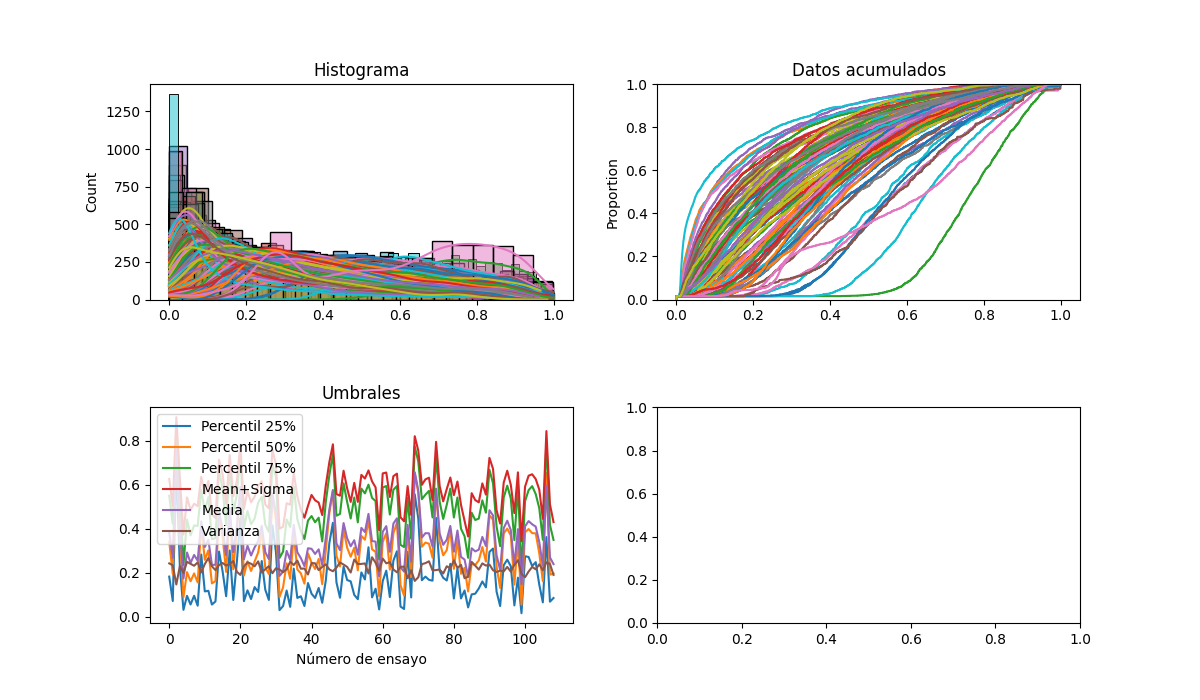

In [32]:
eeg_dfs_ = ensayo4_dfs

# Análisis exploratorio de datos
th25_, th50_, th75_, mean_, sigma_ = plot_estadisticos_ensayos(eeg_dfs_)

In [33]:
df_filtered_04 = filtrado_ensayos(eeg_dfs_, threshold=np.mean(np.array(mean_)+np.array(sigma_)), porcentaje=0.4)
df_filtered_06 = filtrado_ensayos(eeg_dfs_, threshold=np.mean(np.array(mean_)+np.array(sigma_)), porcentaje=0.6)
df_filtered_08 = filtrado_ensayos(eeg_dfs_, threshold=np.mean(np.array(mean_)+np.array(sigma_)), porcentaje=0.8)
df_filtered_10 = filtrado_ensayos(eeg_dfs_, threshold=np.mean(np.array(mean_)+np.array(sigma_)), porcentaje=1.0)

Text(0.5, 1.0, 'Binarizado con umbral para el 100%')

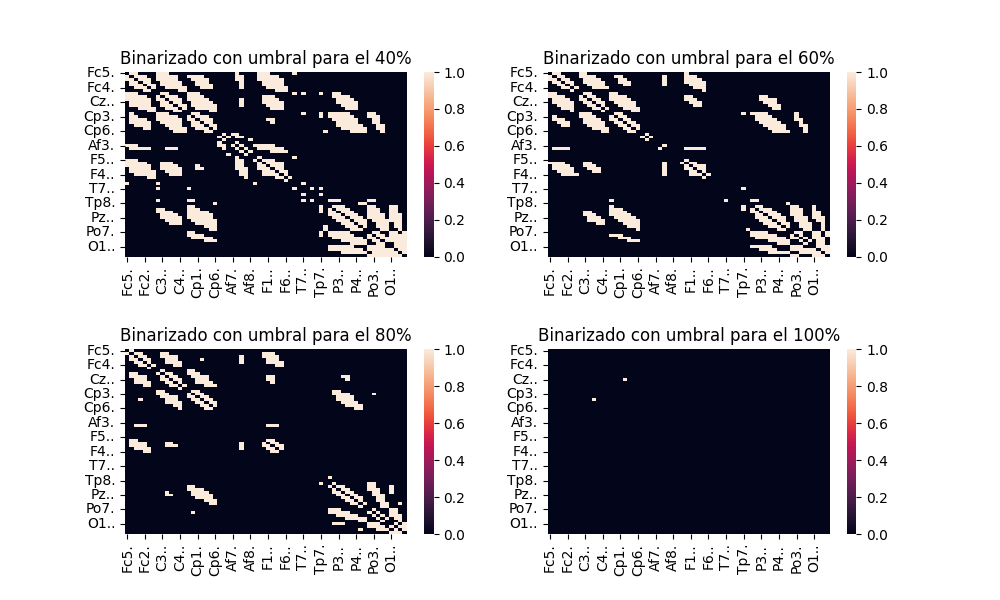

In [34]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

plt.subplots_adjust(hspace=0.5)
sns.heatmap(df_filtered_04, ax=axes[0][0])
sns.heatmap(df_filtered_06, ax=axes[0][1])
sns.heatmap(df_filtered_08, ax=axes[1][0])
sns.heatmap(df_filtered_10, ax=axes[1][1])

axes[0][0].set_title('Binarizado con umbral para el 40%')
axes[0][1].set_title('Binarizado con umbral para el 60%')
axes[1][0].set_title('Binarizado con umbral para el 80%')
axes[1][1].set_title('Binarizado con umbral para el 100%')

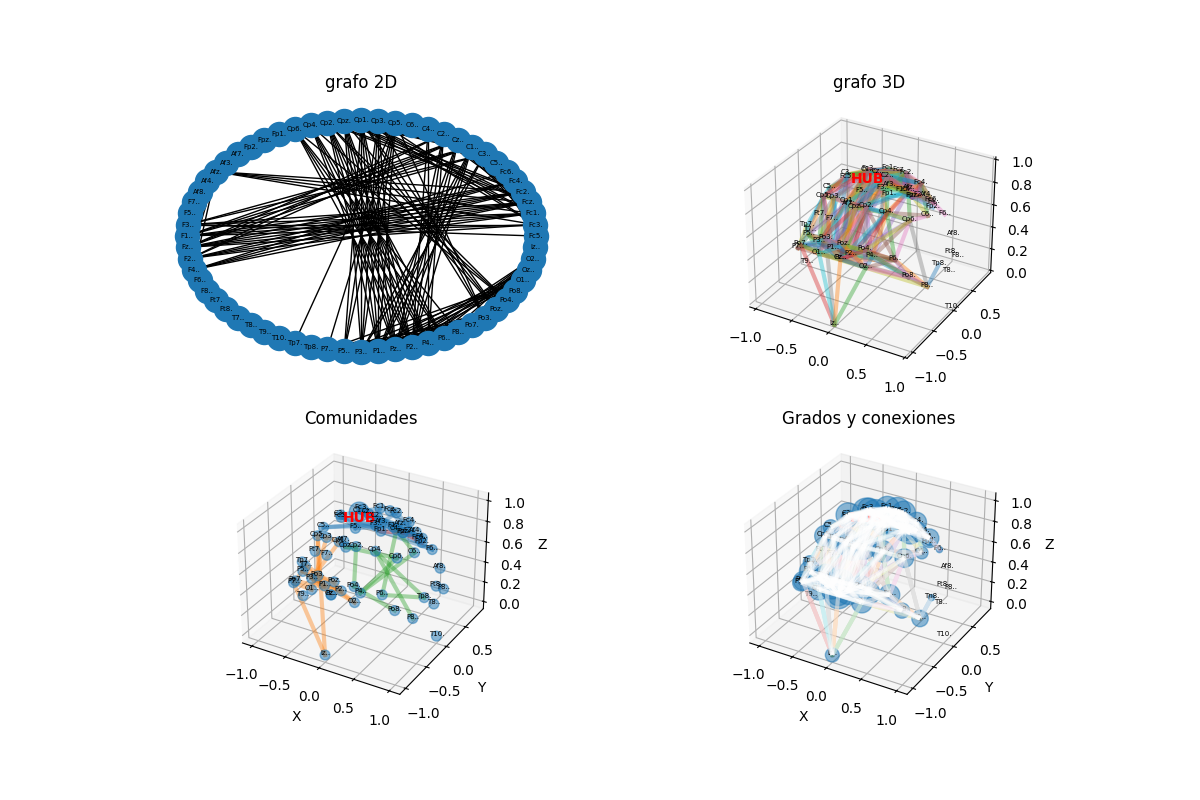

In [35]:
# Generar grafo desde matriz
df_filtered = df_filtered_06
eeg_graph_ = nx.from_pandas_adjacency(df_filtered, create_using=nx.Graph())

clust_coeff, path_length, small_world_sigma, communities, modularity, betweenness, global_eff, local_eff, degree_dict = metricas_grafo(eeg_graph_)

hub = betweenness[0]

plot_grafos(eeg_graph_, df_filtered)


In [36]:
communities

[frozenset({'Af3.',
            'Afz.',
            'C1..',
            'C2..',
            'C3..',
            'C5..',
            'Cz..',
            'F1..',
            'F2..',
            'F3..',
            'F4..',
            'F5..',
            'F6..',
            'Fc1.',
            'Fc2.',
            'Fc3.',
            'Fc4.',
            'Fc5.',
            'Fc6.',
            'Fcz.',
            'Fz..'}),
 frozenset({'Cp1.',
            'Cp3.',
            'Cp5.',
            'Iz..',
            'O1..',
            'O2..',
            'Oz..',
            'P1..',
            'P2..',
            'P3..',
            'P5..',
            'P7..',
            'Po3.',
            'Po7.',
            'Poz.',
            'Pz..',
            'T7..',
            'Tp7.'}),
 frozenset({'C4..',
            'C6..',
            'Cp2.',
            'Cp4.',
            'Cp6.',
            'Cpz.',
            'P4..',
            'P6..',
            'P8..',
            'Po4.',
            'Po8

In [37]:
hub

('C1..', 0.05909973587625574)

In [26]:
len(communities)

14